# Import

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import f1_score
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import os

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [3]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


# Define Mapping

In [5]:

# Define the mapping between attributes and numerical labels
attribute_to_label_mapping = {
    1: {'floral': 0, 'graphic': 1, 'striped': 2, 'embroidered': 3, 'pleated': 4, 'solid': 5, 'lattice': 6},
    2: {'long_sleeve': 7, 'short_sleeve': 8, 'sleeveless': 9},
    3: {'maxi_length': 10, 'mini_length': 11, 'no_dress': 12},
    4: {'crew_neckline': 13, 'v_neckline': 14, 'square_neckline': 15, 'no_neckline': 16},
    5: {'denim': 17, 'chiffon': 18, 'cotton': 19, 'leather': 20, 'faux': 21, 'knit': 22},
    6: {'tight': 23, 'loose': 24, 'conventional': 25}
}


In [6]:
list(attribute_to_label_mapping[1].values())

[0, 1, 2, 3, 4, 5, 6]

In [7]:
total_number_attributes= sum([len(v) for v in attribute_to_label_mapping.values()])

In [8]:
# Define the reverse mapping of numerical labels to attributes
reverse_attribute_mapping = {
    1: {v: k for k, v in attribute_to_label_mapping[1].items()},
    2: {v: k for k, v in attribute_to_label_mapping[2].items()},
    3: {v: k for k, v in attribute_to_label_mapping[3].items()},
    4: {v: k for k, v in attribute_to_label_mapping[4].items()},
    5: {v: k for k, v in attribute_to_label_mapping[5].items()},
    6: {v: k for k, v in attribute_to_label_mapping[6].items()}
}

In [9]:
reverse_attribute_mapping

{1: {0: 'floral',
  1: 'graphic',
  2: 'striped',
  3: 'embroidered',
  4: 'pleated',
  5: 'solid',
  6: 'lattice'},
 2: {7: 'long_sleeve', 8: 'short_sleeve', 9: 'sleeveless'},
 3: {10: 'maxi_length', 11: 'mini_length', 12: 'no_dress'},
 4: {13: 'crew_neckline',
  14: 'v_neckline',
  15: 'square_neckline',
  16: 'no_neckline'},
 5: {17: 'denim',
  18: 'chiffon',
  19: 'cotton',
  20: 'leather',
  21: 'faux',
  22: 'knit'},
 6: {23: 'tight', 24: 'loose', 25: 'conventional'}}

In [10]:
attribute_mapping={
1:list(attribute_to_label_mapping[1].values()),
2:list(attribute_to_label_mapping[2].values()),
3:list(attribute_to_label_mapping[3].values()),
4:list(attribute_to_label_mapping[4].values()),
5:list(attribute_to_label_mapping[5].values()),
6:list(attribute_to_label_mapping[6].values()),
}

sum([len(v) for v in attribute_mapping.values()])

26

# Custom Data Class

In [11]:
num_categories = 6
num_attributes = [7, 3, 3, 4, 6, 3]

In [12]:

from collections import Counter
import pandas as pd 
import numpy as np
import random

class AttributeDataset(Dataset):
    def __init__(self, image_dir, attr_file, image_file, transform=None, oversample=False):
        self.image_dir = image_dir
        self.image_paths = self._read_file(image_file)
        self.labels = self._read_labels(attr_file)
        self.transform = transform
        self.oversample = oversample

        # Convert original labels to numerical labels
        self.converted_numerical_labels = self._convert_to_numerical_labels()

        # Calculate attribute distributions after converting labels
        self.gad = self.get_attribute_distributions()
        print('self.get_attribute_distributions()', self.gad)

        if self.oversample:
            self.image_paths, self.numerical_labels = self._oversample_minority_classes()
            #self.numerical_labels=self._convert_to_numerical_labels(oversample=True)
            print(self.numerical_labels[0])
        else:
            self.numerical_labels = self.labels
            

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor(self.numerical_labels[index], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

    def _read_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
        return [line.strip() for line in lines]

    def _read_labels(self, attr_file):
        labels = []
        with open(attr_file, 'r') as file:
            for line in file:
                labels.append([int(attr) for attr in line.strip().split()])
        return labels

    def _convert_to_numerical_labels(self, oversample=False):
        
        num_attributes = [7, 3, 3, 4, 6, 3]
        result=[]
        
        offset = 0  # Keep track of the starting attribute for each class
        #if oversample==False:
        #    labels = self.labels
        #else:
        #    labels = self.numerical_labels
        for each_label in self.labels:
            offset = 0  # Keep track of the starting attribute for each class
            each_label_result = []
            for i, category in enumerate(each_label):
                
                attribute_value = category + offset #+ 1  # Add 1 since attributes start from 1
                each_label_result.append(attribute_value)

                # Update offset for the next class
                offset += num_attributes[i]
            result.append(each_label_result)
        
        return result
    
    def get_attribute_distributions_wfl(self):
        """Calculates the distribution of attributes across all labels."""
        num_attributes = len(attribute_mapping)
        num_values_per_attribute = [len(values) for values in attribute_mapping.values()]
        attribute_counts = np.zeros((num_attributes, max(num_values_per_attribute)), dtype=np.float32)

        for label in self.numerical_labels:
            for attribute_category, attribute_value in enumerate(label):
                attribute_counts[attribute_category, attribute_value] += 1

        attribute_counts /= len(self.numerical_labels)
        return attribute_counts
    
    
    
    
    def get_attribute_distributions(self):
        """Calculates the distribution of attributes across all labels.

        Returns:
            A NumPy array where each row represents the distribution of a specific attribute
            across the dataset.
        """

        num_attributes = len(attribute_mapping)
        max_attribute_length = max(map(len, attribute_mapping.values()))
        attribute_counts = np.zeros((num_attributes, max_attribute_length))

        for label in self.labels:
            for attribute_index, attribute_value in enumerate(label):
                attribute_counts[attribute_index, attribute_value] += 1
        #print('attribute_counts / len(self.numerical_labels):',attribute_counts / len(self.labels))
        return attribute_counts / len(self.converted_numerical_labels)

    def _oversample_minority_classes(self):
        oversampled_image_paths = []
        oversampled_labels = []
        for image_path, label in zip(self.image_paths, self.labels):
            oversampled_image_paths.append(image_path)
            oversampled_labels.append(label)
            for i, attr in enumerate(label):
                if self.gad[i, attr] < 0.20:  # Oversample if attribute frequency is less than 20%
                    oversampled_image_paths.append(image_path)
                    oversampled_labels.append(label)
        #print('oversampled_labels',oversampled_labels)
        
        # Increase the number of training images and labels by oversampling
        oversampled_image_paths = oversampled_image_paths 
        oversampled_labels = oversampled_labels 
        
        return oversampled_image_paths, oversampled_labels

In [13]:

# with open(dir + 'split/train.txt', 'r') as file:
#     lines = file.readlines()
#     print([dir+line.strip() for line in lines])

In [14]:
# Load and preprocess the data
train_image_paths = []  # List of training image file paths
train_labels = []  # List of training labels
val_image_paths = []  # List of validation image file paths
val_labels = []  # List of validation labels

# Paths

In [15]:
# Load and preprocess the data
dir = './FashionDataset/'

train_image_paths = dir + 'split/train.txt'
train_labels = dir + 'split/train_attr.txt'
val_image_paths = dir + 'split/val.txt'
val_labels = dir + 'split/val_attr.txt'

In [41]:
train_dataset = AttributeDataset(dir, train_labels, train_image_paths, transform=train_transform, oversample=True)
train_dataset[0][0].shape,train_dataset[0][1].shape, train_dataset[0][0].dtype,train_dataset[0][1].dtype


self.get_attribute_distributions() [[0.1536 0.1706 0.0668 0.0844 0.0218 0.4816 0.0212]
 [0.3046 0.1724 0.523  0.     0.     0.     0.    ]
 [0.0976 0.1902 0.7122 0.     0.     0.     0.    ]
 [0.4172 0.1652 0.0038 0.4138 0.     0.     0.    ]
 [0.062  0.1404 0.6798 0.021  0.0096 0.0872 0.    ]
 [0.1498 0.0558 0.7944 0.     0.     0.     0.    ]]
[5, 0, 2, 0, 2, 2]


(torch.Size([3, 224, 224]), torch.Size([6]), torch.float32, torch.int64)

In [42]:
train_dataset = AttributeDataset(dir, train_labels, train_image_paths, transform=train_transform, oversample=True)


self.get_attribute_distributions() [[0.1536 0.1706 0.0668 0.0844 0.0218 0.4816 0.0212]
 [0.3046 0.1724 0.523  0.     0.     0.     0.    ]
 [0.0976 0.1902 0.7122 0.     0.     0.     0.    ]
 [0.4172 0.1652 0.0038 0.4138 0.     0.     0.    ]
 [0.062  0.1404 0.6798 0.021  0.0096 0.0872 0.    ]
 [0.1498 0.0558 0.7944 0.     0.     0.     0.    ]]
[5, 0, 2, 0, 2, 2]


In [43]:
train_dataset[1]

(tensor([[[-2.1179, -1.1760,  0.6049,  ...,  1.7009,  1.7009,  1.7009],
          [-2.1179, -1.1760,  0.6049,  ...,  1.7009,  1.7009,  1.7009],
          [-2.1179, -1.1760,  0.6049,  ...,  1.7009,  1.7009,  1.7009],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -1.0553,  0.8004,  ...,  1.9559,  1.9559,  1.9559],
          [-2.0357, -1.0553,  0.8004,  ...,  1.9559,  1.9559,  1.9559],
          [-2.0357, -1.0553,  0.8004,  ...,  1.9559,  1.9559,  1.9559],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -0.8633,  0.8971,  ...,  2.0474,  2.0474,  2.0474],
          [-1.8044, -0.8633,

In [44]:
val_dataset = AttributeDataset(dir,dir+'/split/val_attr.txt', dir+'/split/val.txt', transform=val_transform)
val_dataset[10]

self.get_attribute_distributions() [[0.192 0.175 0.065 0.077 0.013 0.458 0.02 ]
 [0.301 0.168 0.531 0.    0.    0.    0.   ]
 [0.1   0.173 0.727 0.    0.    0.    0.   ]
 [0.387 0.173 0.002 0.438 0.    0.    0.   ]
 [0.056 0.146 0.68  0.016 0.01  0.092 0.   ]
 [0.129 0.07  0.801 0.    0.    0.    0.   ]]


(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2318, 2.1462],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2147],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4111, 2.3235],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.3936],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6226, 2.5354],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6051],
          [2.6400, 2.6400, 2.6400,  ...,

# Set Device

In [20]:
# Set device

# Check for Apple Silicon GPU (MPS)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# Model

python3.11 -m pip install torchsummary

# Selected Model

## Using Resnet101

In [21]:
# # Define the model
# class AttributeModel(nn.Module):
#     def __init__(self, num_categories, num_attributes):
#         super(AttributeModel, self).__init__()
#         self.base_model = models.resnet101(pretrained=True)
#         #self.base_model=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
#         self.base_model.fc = nn.Linear(2048, 512)
        
#         self.attribute_classifiers = nn.ModuleList()
#         for i in range(num_categories):
#             self.attribute_classifiers.append(nn.Sequential(
#                 nn.ReLU(),
#                 nn.Linear(512, num_attributes[i])
#             ))
        
#         # self.attribute_classifiers = nn.ModuleList(
#         #     [nn.Linear(512, num_attributes[i]),  for i in range(num_categories)])
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         features = self.base_model(x)
#         features = self.dropout(features)
#         #features=self.base_model(x)
#         #features = self.dropout2(features)
#         attributes = [classifier(features) for classifier in self.attribute_classifiers]
#         #attributes = torch.stack(attributes, dim=0)
#         #print(attributes.shape, attributes.dtype)
#         #print('attributes:',attributes, len(attributes), attributes[0].shape, attributes[0].dtype)
#         return attributes

# Using Efficientnet with CBAM - convolutional block attention module

In [22]:
# import torch.nn as nn
# from torchvision import models

# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, reduction_ratio=32):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels // reduction_ratio, 1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels // reduction_ratio, in_channels, 1)
#         )

#     def forward(self, x):
#         avg_out = self.fc(self.avg_pool(x))
#         max_out = self.fc(self.max_pool(x))
#         out = avg_out + max_out
#         return torch.sigmoid(out)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=3):
#         super(SpatialAttention, self).__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         out = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(out)
#         return torch.sigmoid(out)

# class CBAM(nn.Module):
#     def __init__(self, in_channels, reduction_ratio=32, kernel_size=5):
#         super(CBAM, self).__init__()
#         self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
#         self.spatial_attention = SpatialAttention(kernel_size)

#         # Initialize weights for CBAM
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         out = self.channel_attention(x) * x
#         out = self.spatial_attention(out) * out
#         return out

# class AttributeModel(nn.Module):
#     def __init__(self, num_categories, num_attributes):
#         super(AttributeModel, self).__init__()
#         self.base_model = models.efficientnet_v2_l(pretrained=True)
#         self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])

#         last_conv_layer = None
#         for layer in self.base_model.modules():
#             if isinstance(layer, nn.Conv2d):
#                 last_conv_layer = layer

#         if last_conv_layer is not None:
#             last_layer_output_size = last_conv_layer.out_channels
#         else:
#             raise ValueError("No convolutional layer found in the base model.")

#         self.cbam = CBAM(last_layer_output_size)

#         self.attribute_classifiers = nn.ModuleList()
#         for i in range(num_categories):
#             self.attribute_classifiers.append(nn.Sequential(
#                 nn.AdaptiveAvgPool2d(1),
#                 nn.Flatten(),
#                 nn.Linear(last_layer_output_size, 1024),
#                 nn.BatchNorm1d(1024),
#                 nn.ReLU(),
#                 nn.Dropout(0.5),
#                 nn.Linear(1024, 512),
#                 nn.BatchNorm1d(512),
#                 nn.ReLU(),
#                 nn.Dropout(0.5),
#                 nn.Linear(512, 256),
#                 nn.BatchNorm1d(256),
#                 nn.ReLU(),
#                 nn.Dropout(0.5),
#                 nn.Linear(256, num_attributes[i])
#             ))

#         self.dropout = nn.Dropout(0.5)

#         # Initialize weights for attribute classifiers
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         features = self.base_model(x)
#         features = self.cbam(features)
#         features = self.dropout(features)
#         attributes = [classifier(features) for classifier in self.attribute_classifiers]
#         return attributes

In [23]:
import torch.nn as nn
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=32):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1)
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.channel_attention(x) * x
        out = self.spatial_attention(out) * out
        return out

# class AttributeModel(nn.Module):
#     def __init__(self, num_categories, num_attributes):
#         super(AttributeModel, self).__init__()
#         # Load EfficientNet_B0
#         #self.base_model = models.efficientnet_b0(pretrained=True)
#         self.base_model=models.efficientnet_v2_l(pretrained=True)
#         self.base_model = self.base_model.features  # Use features instead of the entire model
#         self.cbam = CBAM(1280)  # Adjust the input size of CBAM
#         self.attribute_classifiers = nn.ModuleList()
#         for i in range(num_categories):
#             self.attribute_classifiers.append(nn.Sequential(
#                 nn.AdaptiveAvgPool2d(1),  # Add global average pooling
#                 nn.Flatten(),  # Flatten the features
#                 nn.ReLU(),
#                 nn.Linear(1280, 512),  # Adjust the input size of the linear layer
#                 nn.BatchNorm1d(512),
#                 nn.ReLU(),
#                 nn.Linear(512, 256),  # Adjust the input size of the linear layer
#                 nn.BatchNorm1d(256),
#                 nn.ReLU(),
#                 nn.Dropout(0.5),
#                 nn.Linear(256, num_attributes[i])
#             ))
#         self.dropout = nn.Dropout(0.5)

class AttributeModel(nn.Module):
    def __init__(self, num_categories, num_attributes):
        super(AttributeModel, self).__init__()
        self.base_model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1) #efficientnet_v2_l(pretrained=True)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])  # Remove the last two layers

        # Find the last convolutional layer in the base model
        last_conv_layer = None
        for layer in self.base_model.modules():
            if isinstance(layer, nn.Conv2d):
                last_conv_layer = layer

        if last_conv_layer is not None:
            last_layer_output_size = last_conv_layer.out_channels
        else:
            raise ValueError("No convolutional layer found in the base model.")

        self.cbam = CBAM(last_layer_output_size)  # Adjust the input size of CBAM

        self.attribute_classifiers = nn.ModuleList()
        for i in range(num_categories):
            self.attribute_classifiers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(2),  # Change the output size to 2x2
                nn.Flatten(),
                nn.Linear(last_layer_output_size * 4, 1024),  # Adjust the input size of the linear layer
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(256, num_attributes[i])
            ))
        
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        # Extract features from the base model
        features = self.base_model(x)
        features = self.cbam(features)  # Apply CBAM to the features
        features = self.dropout(features)
        
        # Ensure the spatial dimensions are divisible by the output size of AdaptiveAvgPool2d
        output_size = 2
        h, w = features.shape[2], features.shape[3]
        new_h, new_w = (h // output_size) * output_size, (w // output_size) * output_size
        features = nn.functional.interpolate(features, size=(new_h, new_w), mode='bilinear', align_corners=False)

        
        attributes = [torch.softmax(classifier(features), dim=1) for classifier in self.attribute_classifiers]

        # Get predictions for each attribute
        #attributes = [classifier(features) for classifier in self.attribute_classifiers]
        return attributes

        # self.attribute_classifiers = nn.ModuleList()
        # for i in range(num_categories):
        #     self.attribute_classifiers.append(nn.Sequential(
        #         nn.AdaptiveAvgPool2d(1),
        #         nn.Flatten(),
        #         nn.Linear(last_layer_output_size, 1024),  # Increase the width
        #         nn.BatchNorm1d(1024),
        #         nn.ReLU(),
        #         nn.Dropout(0.5),
        #         nn.Linear(1024, 512),  # Increase the width
        #         nn.BatchNorm1d(512),
        #         nn.ReLU(),
        #         nn.Dropout(0.5),
        #         nn.Linear(512, 256),  # Increase the width
        #         nn.BatchNorm1d(256),
        #         nn.ReLU(),
        #         nn.Dropout(0.5),
        #         nn.Linear(256, num_attributes[i])
        #     ))
        # self.dropout = nn.Dropout(0.5)


    # def forward(self, x):
    #     # Extract features from the base model
    #     features = self.base_model(x)
    #     features = self.cbam(features)  # Apply CBAM to the features
    #     features = self.dropout(features)
    #     attributes = [torch.softmax(classifier(features), dim=1) for classifier in self.attribute_classifiers]

    #     # Get predictions for each attribute
    #     #attributes = [classifier(features) for classifier in self.attribute_classifiers]
    #     return attributes

In [24]:
from torchsummary import summary
summary(AttributeModel(num_categories,num_attributes), (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
   StochasticDepth-7         [-1, 32, 112, 112]               0
       FusedMBConv-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,216
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             SiLU-11         [-1, 32, 112, 112]               0
  StochasticDepth-12         [-1, 32, 112, 112]               0
      FusedMBConv-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

# Move Model

In [25]:
model = AttributeModel(num_categories,num_attributes)
model.to(device) 

AttributeModel(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32,

# Number of Trainable Parameters

In [26]:
# Print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 152868829


# Weighted BCE Focal Loss

In [27]:
# import torch
# import torch.nn as nn

# class WeightedBCEFocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean', smoothing=0.1, epsilon=1e-7):
#         super(WeightedBCEFocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         self.smoothing = smoothing
#         self.epsilon = epsilon

#     def forward(self, inputs, targets, weights):
#         # Ensure targets is a float tensor and on the same device as inputs
#         targets = targets.float().to(inputs.device)

#         # Apply sigmoid to compute probabilities
#         probabilities = torch.sigmoid(inputs)

#         # Apply label smoothing
#         targets = (1 - self.smoothing) * targets + self.smoothing * 0.5

#         # Clip probabilities to avoid log(0) which can cause NaN
#         probabilities = torch.clamp(probabilities, self.epsilon, 1 - self.epsilon)

#         # Compute the focal loss components
#         cross_entropy_loss = -targets * torch.log(probabilities) - (1 - targets) * torch.log(1 - probabilities)
#         pt = probabilities * targets + (1 - probabilities) * (1 - targets)
#         focal_loss = self.alpha * torch.pow(1 - pt, self.gamma) * cross_entropy_loss

#         # Apply weights to the focal loss
#         # No need to reshape weights, assuming they are already in the correct shape
#         weighted_loss = focal_loss * weights.to(inputs.device)

#         # Reduction
#         if self.reduction == 'mean':
#             return torch.mean(weighted_loss)
#         elif self.reduction == 'sum':
#             return torch.sum(weighted_loss)
#         else:
#             return weighted_loss


In [28]:
# class WeightedBCEFocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean', smoothing=0.1):
#         super(WeightedBCEFocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         self.smoothing = smoothing

#     def forward(self, inputs, targets, weights):
#         targets = targets.unsqueeze(-1)
#         targets = targets.expand_as(inputs)

#         # Apply sigmoid activation to get probabilities
#         probabilities = torch.sigmoid(inputs)

#         # Apply label smoothing
#         targets = (1 - self.smoothing) * targets + self.smoothing / 2

#         # Compute binary cross-entropy loss
#         bce_loss = nn.functional.binary_cross_entropy(probabilities, targets, reduction='none')

#         # Compute focal loss
#         pt = probabilities * targets + (1 - probabilities) * (1 - targets)
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

#         # Compute class-specific weights
#         class_weights = weights.gather(0, targets.long().view(-1)).view(*focal_loss.shape)

#         # Apply class-specific weights to the focal loss
#         weighted_loss = class_weights * focal_loss

#         if self.reduction == 'mean':
#             return torch.mean(weighted_loss)
#         elif self.reduction == 'sum':
#             return torch.sum(weighted_loss)
#         else:
#             return weighted_loss

# WeightedFocalLoss

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

class WeightedFocalLoss(nn.Module):
    def __init__(self, alphas, gamma=2.1, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        self.alphas = alphas
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='sum') #default is None
        pt = torch.exp(-ce_loss)
        targets = targets.long()  # Convert targets to long tensor
        alpha_tensor = self.alphas[targets]
        F_loss = alpha_tensor * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [30]:
# class WeightedFocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean'):
#         super(WeightedFocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets, weights):
#         ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         F_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         weighted_loss = weights * F_loss

#         if self.reduction == 'mean':
#             return torch.mean(weighted_loss)
#         elif self.reduction == 'sum':
#             return torch.sum(weighted_loss)
#         else:
#             return weighted_loss

# Set up hyperameters

In [31]:
# Set hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Define Data Transform

In [32]:
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.95, 1.05)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#     transforms.RandomRotation(degrees=15),
#     transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
#     transforms.RandomGrayscale(p=0.1),
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#     transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Set up data augmentation and preprocessing
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [33]:
# Define data transforms
# Set up data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop( size=(224, 224), scale=(0.95, 1.05)),  
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.RandomRotation(degrees=5),
    #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set up data augmentation and preprocessing
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset

In [34]:
dir= './FashionDataset/'

# Load the dataset
train_dataset = AttributeDataset(dir,dir+'/split/train_attr.txt', dir+'/split/train.txt', transform=train_transform,oversample=True)
val_dataset = AttributeDataset(dir,dir+'/split/val_attr.txt', dir+'/split/val.txt', transform=val_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataset[0], val_dataset[0],train_dataset[0][0].shape, train_dataset[0][1].shape 

self.get_attribute_distributions() [[0.1536 0.1706 0.0668 0.0844 0.0218 0.4816 0.0212]
 [0.3046 0.1724 0.523  0.     0.     0.     0.    ]
 [0.0976 0.1902 0.7122 0.     0.     0.     0.    ]
 [0.4172 0.1652 0.0038 0.4138 0.     0.     0.    ]
 [0.062  0.1404 0.6798 0.021  0.0096 0.0872 0.    ]
 [0.1498 0.0558 0.7944 0.     0.     0.     0.    ]]
[5, 0, 2, 0, 2, 2]
self.get_attribute_distributions() [[0.192 0.175 0.065 0.077 0.013 0.458 0.02 ]
 [0.301 0.168 0.531 0.    0.    0.    0.   ]
 [0.1   0.173 0.727 0.    0.    0.    0.   ]
 [0.387 0.173 0.002 0.438 0.    0.    0.   ]
 [0.056 0.146 0.68  0.016 0.01  0.092 0.   ]
 [0.129 0.07  0.801 0.    0.    0.    0.   ]]


((tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.0323, -2.0323, -2.0323],
           ...,
           [-2.1179, -2.1179, -2.1179,  ...,  1.7523,  1.7523,  1.7180],
           [-2.1179, -2.1179, -2.1179,  ...,  1.7523,  1.7523,  1.7180],
           [-2.1179, -2.1179, -2.1179,  ...,  1.7523,  1.7523,  1.7180]],
  
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -1.9482, -1.9482, -1.9482],
           ...,
           [-2.0357, -2.0357, -2.0357,  ...,  1.9209,  1.9209,  1.8859],
           [-2.0357, -2.0357, -2.0357,  ...,  1.9209,  1.9209,  1.8859],
           [-2.0357, -2.0357, -2.0357,  ...,  1.9209,  1.9209,  1.8859]],
  
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           

# Criterion, Optimizer, scheduler

In [35]:
# # Define the model
num_categories = 6
num_attributes = [7, 3, 3, 4, 6, 3]
# model = AttributeModel(num_categories,num_attributes)
# model.to(device)

#criterion = WeightedBCEFocalLoss(alpha=1, gamma=2, reduction='mean')
#criterion = WeightedFocalLoss(alphas=1, gamma=2, reduction='mean')
#criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1, eta_min=1e-6)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Avg Class Acc

In [36]:
def compute_avg_class_acc(gt_labels, pred_labels):
    num_classes = np.unique(gt_labels).size  # Get the number of unique classes
    per_class_acc = []
    for idx in range(num_classes):
        mask = (gt_labels == idx)
        if np.sum(mask) > 0:
            correct = np.sum((gt_labels[mask] == pred_labels[mask]))
            total = np.sum(mask)
            per_class_acc.append(float(correct) / float(total))
    if len(per_class_acc) > 0:
        return np.mean(per_class_acc)
    else:
        return 0.0

# Training

In [37]:
# for param in model.parameters():
#     assert param.requires_grad, "Parameters should require gradients"

In [38]:
# Train the model
num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []
val_avg_class_accs = []
best_val_loss = float('inf')
best_val_avg_class_accs = 0#float('inf')

In [39]:
# Calculate attribute frequencies
attribute_counts = train_dataset.get_attribute_distributions_wfl()
attribute_weights = 1 / attribute_counts
#attribute_weights /= torch.sum(attribute_weights, dim=0, keepdim=True)
attribute_weights /= np.sum(attribute_weights, axis=0, keepdims=True)
attribute_weights = torch.from_numpy(attribute_weights).float().to(device)

#attribute_weights = attribute_weights.to(device)

/var/folders/_6/2sxd3q_d65b9mp5y1l5_0g7r0000gn/T/ipykernel_72464/1301744148.py:3: RuntimeWarning: divide by zero encountered in divide
  attribute_weights = 1 / attribute_counts
/var/folders/_6/2sxd3q_d65b9mp5y1l5_0g7r0000gn/T/ipykernel_72464/1301744148.py:5: RuntimeWarning: invalid value encountered in divide
  attribute_weights /= np.sum(attribute_weights, axis=0, keepdims=True)


In [40]:
# Compute attribute frequencies within each class
attribute_counts = defaultdict(lambda: defaultdict(int))
for _, labels in train_loader:
    labels = labels.to(device)  # Move labels to the same device as the model
    for i in range(num_categories):
        for attribute in labels[:, i].cpu().numpy():
            attribute_counts[i][attribute] += 1

# Compute alphas based on attribute frequencies within each class
alphas = {}
for category in range(num_categories):
    total_count = sum(attribute_counts[category].values())
    alphas[category] = {attr: total_count / float(count) for attr, count in attribute_counts[category].items()}

# Create WeightedFocalLoss instances for each category
criterion = {}
for category in range(num_categories):
    alphas_tensor = torch.tensor([alphas[category][attr] for attr in sorted(alphas[category].keys())], dtype=torch.float32, device=device)
    criterion[category] = WeightedFocalLoss(alphas_tensor)

In [45]:
from collections import defaultdict

start_time = time.time()


for epoch in range(num_epochs):
    epoch_start_time= time.time()
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        losses = []
        #print('outputs:',outputs.shape, outputs.dtype)
        #print('labels:',labels.shape,labels.dtype)
        #loss=criterion(outputs, labels)
        for i in range(num_categories):
            output = outputs[i] #each category has different number of attributes
            target = labels[:,i]
            

            #loss = criterion(output, target)
            eachOutputloss=[]
            for each_category_output, each_category_target in zip(output, target):
                loss = criterion[i](each_category_output, each_category_target)
                eachOutputloss.append(loss) #each batch loss
            #loss = criterion(output.unsqueeze(-1), target)
        #     losses.append(loss)
            losses.append(sum(eachOutputloss)) #eac category loss
        
        loss = sum(losses)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() #* images.size(0)   
    
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss) #train_losses for graph plotting

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_pred_labels = []
    val_pred_labels_dict=defaultdict(list)
    val_gt_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            
            outputs = model(images)
            
            losses = []
            for i in range(num_categories):
                output = outputs[i] #each category has different number of attributes
                target = labels[:,i]
                #loss = criterion(output, target)
                eachOutputloss=[]
                for each_category_output, each_category_target in zip(output, target):
                    loss = criterion[i](each_category_output, each_category_target)
                    eachOutputloss.append(loss)
                #loss = criterion(output, target)
                #losses.append(loss)
                losses.append(sum(eachOutputloss))
                
            val_loss += sum(losses).item() #* images.size(0)
            
            labels_np = labels.cpu().numpy()
            predicted_attributes={
                0:[],
                1:[],
                2:[],
                3:[],
                4:[],
                5:[]}
            #val_correct=0
            for category_indx, output in enumerate(outputs): #outputs contains 6 categories of attributes over a batch.
                #val_correct=0
                predicted_attributes_byCategory=[]
                
                for i in range(len(output)):
                    #print(output[i].argmax())
                    #print(labels_np[i,category_indx])
                    #predicted_attribute.append(output[i].argmax())
                    if torch.isclose(output[i].argmax().float(), torch.tensor(labels_np[i,category_indx]), atol=0.45, rtol=0.45):  # Tolerance for differences, default atol=0.01
                        val_correct+=1
                    predicted_attributes_byCategory.append(output[i].argmax())
                predicted_attributes[category_indx].extend(predicted_attributes_byCategory) #append batch by its respective category
                
                
                val_total += labels_np.size
            
            for key, value in predicted_attributes.items():
                val_pred_labels_dict[key].extend(value)
            val_pred_labels=[val_pred_labels_dict[0],
                             val_pred_labels_dict[1],
                             val_pred_labels_dict[2],
                             val_pred_labels_dict[3],
                             val_pred_labels_dict[4],
                             val_pred_labels_dict[5]]
            
            #val_pred_labels.extend(predicted_attributes)
            val_gt_labels.extend(labels_np)
            
        # Function to move a single tensor to CPU 
        def tensor_to_cpu(tensor):
            return tensor.detach().cpu()  # Detach is optional depending on your use case

        # Apply the function to each tensor in the list
        val_pred_labels1 = [[tensor_to_cpu(tensor) for tensor in inner_list] for inner_list in val_pred_labels]

            
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_pred_labels2=zip(*[val_pred_labels1[i] for i in range(num_categories)])


        val_avg_class_acc = compute_avg_class_acc(np.array(val_gt_labels), np.array([i for i in val_pred_labels2]))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_avg_class_accs.append(val_avg_class_acc)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Avg Class Acc: {val_avg_class_acc:.4f}, Epoch Time: {epoch_time:.2f}s")
    
    if val_avg_class_acc > best_val_avg_class_accs and val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_combined_model.pth")
    if val_avg_class_acc > best_val_avg_class_accs:
        best_val_avg_class_accs = val_avg_class_acc
        torch.save(model.state_dict(), "best_model.pth")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_loss_model.pth")

        
    scheduler.step()

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f}s")


Epoch [1/30], Train Loss: 746.6618, Val Loss: 568.5981, Val Accuracy: 0.1093, Val Avg Class Acc: 0.4719, Epoch Time: 715.87s
Epoch [2/30], Train Loss: 604.5292, Val Loss: 492.4785, Val Accuracy: 0.1161, Val Avg Class Acc: 0.5697, Epoch Time: 638.14s
Epoch [3/30], Train Loss: 519.4804, Val Loss: 468.0679, Val Accuracy: 0.1208, Val Avg Class Acc: 0.6100, Epoch Time: 639.08s
Epoch [4/30], Train Loss: 489.5055, Val Loss: 442.4370, Val Accuracy: 0.1288, Val Avg Class Acc: 0.6349, Epoch Time: 638.82s
Epoch [5/30], Train Loss: 434.3918, Val Loss: 418.2424, Val Accuracy: 0.1361, Val Avg Class Acc: 0.6674, Epoch Time: 631.52s
Epoch [6/30], Train Loss: 394.7715, Val Loss: 403.5700, Val Accuracy: 0.1354, Val Avg Class Acc: 0.6993, Epoch Time: 635.25s
Epoch [7/30], Train Loss: 406.3320, Val Loss: 428.2052, Val Accuracy: 0.1358, Val Avg Class Acc: 0.6565, Epoch Time: 635.27s
Epoch [8/30], Train Loss: 376.0633, Val Loss: 411.3825, Val Accuracy: 0.1382, Val Avg Class Acc: 0.7092, Epoch Time: 634.46s


KeyboardInterrupt: 

In [290]:
torch.save(model.state_dict(), "best_model_last.pth")

# Plot Training Curves

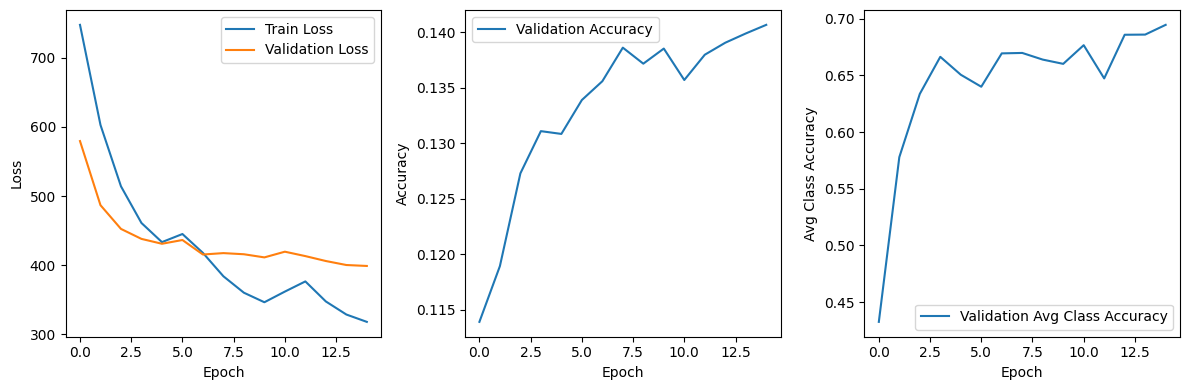

In [293]:
# Plot the training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(val_avg_class_accs, label='Validation Avg Class Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Avg Class Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Testing 

In [295]:
# Set up data augmentation and preprocessing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [296]:
# Define the test dataset without labels
class TestDataset(Dataset):
    def __init__(self, image_dir, image_file, transform=None):
        self.image_dir = image_dir
        self.image_paths = self._read_file(image_file)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_paths[index])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

    def _read_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
        return [line.strip() for line in lines]

# Load the best model and make predictions on the test set
test_dataset = TestDataset(dir,dir+'/split/test.txt', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load("best_model.pth"))
#model.load_state_dict(torch.load("best_model_last.pth"))
#model.load_state_dict(torch.load"best_loss_model.pth")
model.eval()



AttributeModel(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32,

In [298]:
predictions = []
with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        batch_predictions = torch.stack([output.argmax(dim=1) for output in outputs], dim=1)
        predictions.extend(batch_predictions.tolist())

# Save the predictions to a file in the same format as val_attr.txt
with open("prediction.txt", "w") as file:
    for pred in predictions:
        file.write(" ".join(map(str, pred)) + "\n")

print("Test predictions saved to test_predictions.txt")

Test predictions saved to test_predictions.txt


In [299]:
def count_lines_readlines(file_path):
    """Counts lines using the readlines() function."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
        return len(lines)

# Example usage:
file_name = "prediction.txt"
num_lines = count_lines_readlines(file_name)
print("Number of lines:", num_lines)


Number of lines: 1000


# Code Testing Section